In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
import keras
from keras.models import Sequential
from keras.layers import Dense, LocallyConnected2D, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using plaidml.keras.backend backend.


In [2]:
train = open('data/sign_mnist_train.csv')
test = open('data/sign_mnist_test.csv')

train_df = pd.read_csv(train)
test_df = pd.read_csv(test)

# labels represents letters. 
train_y_values = train_df.label.values
test_y_values = test_df.label.values

label_binarizer = LabelBinarizer()
train_y_values = label_binarizer.fit_transform(train_y_values)
test_y_values = label_binarizer.fit_transform(test_y_values)

train_df.drop('label', axis=1, inplace=True)
test_df.drop('label', axis=1, inplace=True)

In [3]:
train_images = np.array([row.values.reshape(28, 28) for i, row in train_df.iterrows()])
test_images = np.array([row.values.reshape(28, 28) for i, row in test_df.iterrows()])
#train_images = train_images / 255
#test_images = test_images / 255

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(train_images, train_y_values, 
                                                      test_size = 0.2,
                                                      random_state = 64209)

x_train = np.array(x_train)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_valid = np.array(x_valid)
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28, 1)

In [5]:
train_datagen = ImageDataGenerator(shear_range = 0.25,
                                   zoom_range = 0.15,
                                   rotation_range = 15,
                                   brightness_range = [0.15, 1.15],
                                   width_shift_range = [-2,-1, 0, +1, +2],
                                   height_shift_range = [ -1, 0, +1],
                                   fill_mode = 'reflect')
test_datagen = ImageDataGenerator()

#train_datagen.fit(x_train)
#train_datagen.fit(x_valid)

In [6]:
batch_size = 32
num_classes = 24
epochs = 64

In [7]:
def modelMaker(dropout_rate=.40, l2_rate=.001, dense_size=64):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(4, 4), input_shape=(28, 28, 1), 
              kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(keras.layers.PReLU(alpha_initializer='zeros', 
                                 alpha_regularizer=None, alpha_constraint=None, 
                                 shared_axes=None))
    model.add(AveragePooling2D(pool_size = (2, 2), strides=2))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, kernel_size = (4, 4), kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(keras.layers.PReLU(alpha_initializer='zeros', 
                                 alpha_regularizer=None, alpha_constraint=None, 
                                 shared_axes=None))
    model.add(AveragePooling2D(pool_size = (2, 2), strides=2))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, kernel_size = (3, 3), kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(keras.layers.PReLU(alpha_initializer='zeros', 
                                 alpha_regularizer=None, alpha_constraint=None, 
                                 shared_axes=None))
    model.add(AveragePooling2D(pool_size = (2, 2), strides=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(dense_size, kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(keras.layers.PReLU(alpha_initializer='zeros', 
                                 alpha_regularizer=None, alpha_constraint=None, 
                                 shared_axes=None))
    model.add(Dense(num_classes, activation = 'softmax'))

    model.compile(loss = keras.losses.kullback_leibler_divergence, 
                  optimizer=keras.optimizers.Nadam(),metrics=['accuracy'])
    return model

model = modelMaker()

INFO:plaidml:Opening device "opencl_amd_gfx900.0"


In [8]:
history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), 
                    epochs=epochs, batch_size=batch_size)

Train on 21964 samples, validate on 5491 samples
Epoch 1/64
21964/21964 [==============================] - 18s 808us/step - loss: 1.9277 - acc: 0.4748 - val_loss: 0.6522 - val_acc: 0.8875
Epoch 2/64
21964/21964 [==============================] - 6s 295us/step - loss: 0.7672 - acc: 0.8488 - val_loss: 0.4279 - val_acc: 0.9730
Epoch 3/64
21964/21964 [==============================] - 6s 295us/step - loss: 0.8277 - acc: 0.8732 - val_loss: 0.5098 - val_acc: 0.9816
Epoch 4/64
21964/21964 [==============================] - 7s 300us/step - loss: 0.6453 - acc: 0.9173 - val_loss: 0.5207 - val_acc: 0.9430
Epoch 5/64
21964/21964 [==============================] - 7s 300us/step - loss: 0.5763 - acc: 0.9336 - val_loss: 0.3893 - val_acc: 0.9909
Epoch 6/64
21964/21964 [==============================] - 7s 298us/step - loss: 0.5379 - acc: 0.9421 - val_loss: 0.3671 - val_acc: 0.9975
Epoch 7/64
21964/21964 [==============================] - 7s 308us/step - loss: 0.5678 - acc: 0.9352 - val_loss: 0.3943 - 

21964/21964 [==============================] - 7s 335us/step - loss: 0.5491 - acc: 0.9548 - val_loss: 0.4078 - val_acc: 1.0000
Epoch 60/64
21964/21964 [==============================] - 7s 333us/step - loss: 0.4999 - acc: 0.9657 - val_loss: 0.3719 - val_acc: 0.9934
Epoch 61/64
21964/21964 [==============================] - 7s 324us/step - loss: 0.4943 - acc: 0.9608 - val_loss: 0.3575 - val_acc: 0.9995
Epoch 62/64
21964/21964 [==============================] - 7s 324us/step - loss: 0.4781 - acc: 0.9616 - val_loss: 0.3752 - val_acc: 0.9991
Epoch 63/64
21964/21964 [==============================] - 7s 330us/step - loss: 0.5141 - acc: 0.9586 - val_loss: 0.4039 - val_acc: 0.9998
Epoch 64/64
21964/21964 [==============================] - 7s 337us/step - loss: 0.5671 - acc: 0.9542 - val_loss: 0.4326 - val_acc: 0.9989


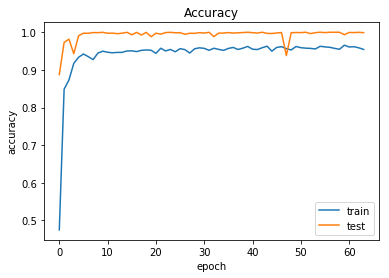

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

In [10]:
test_images = np.array([i.flatten() for i in test_images])
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
y_pred = model.predict(test_images)

accuracy_score(test_y_values, y_pred.round())



0.9552426101505856